In [1]:
from keras.models import Model
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Input, Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
import gensim
from gensim.models import word2vec
import logging
import  tensorflow as tf
from collections import Counter
import nltk
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import urllib.request
import os
import sys
import zipfile
import logging
import pydot
import graphviz
import re
import re
from functools import reduce
from collections import defaultdict
import collections
import nltk
from nltk.corpus import brown
import wordsegment
from wordsegment import load, segment
from operator import itemgetter
import keras
import pickle

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

logging.basicConfig(level=logging.DEBUG)

In [3]:
file = open('/users/rachelchen/downloads/conv.pkl', 'rb')

# dump information to that file
data = pickle.load(file)

# close the file
file.close()

In [4]:
data = pd.DataFrame(data[:20000],columns=['Context','Utterance'])

In [5]:
data = pd.read_csv("train.csv")

In [5]:
def tokenize(sent):
    '''Return the tokens of a sentence including punctuation.
    >>> tokenize('Bob dropped the apple. Where is the apple?')
    ['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']
    '''
    return [x.strip() for x in re.findall(r"[\w']+|[.,!?]", sent) if x.strip()]

In [6]:
def get_data(data):
    questions = data.Context.apply(tokenize).values
    answers = data.Utterance.apply(tokenize).values

    #questions.apply(tokenize)
    #answers.apply(tokenize)

    data = [(q, a) for q, a in zip(questions, answers)]
    return data

In [7]:
train = get_data(data)

In [8]:
data.head()

,Context,Utterance
0,"well , i thought we'd start with pronunciation...",not the hacking and gagging and spitting part ...
1,not the hacking and gagging and spitting part ...,okay . then how 'bout we try out some french c...
2,you're asking me out . that's so cute . what's...,forget it .
3,"no , no , it's my fault we didn't have a prope...",cameron . cameron .
4,cameron . cameron .,"the thing is , cameron i'm at the mercy of a p..."


In [9]:
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "i would",
"i'd" : "i had",
"i'll" : "i will",
"i'm" : "i am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "i have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
    }

In [10]:
def pre_process(qa):
    
    question,answer = qa
    w_q = [w.lower() for w in question if (len(w)!=1)|(w.isalpha())]
    
    w_a = [w.lower() for w in answer if (len(w)!=1)|(w.isalpha())]
    w_q = [APPO[word] if word in APPO else word for word in w_q]
    w_a = [APPO[word] if word in APPO else word for word in w_a]
    q = " ".join(w_q)
    a = " ".join(w_a)
    return (q,a)

In [11]:
train = list(map(pre_process,train))

In [12]:
data = pd.DataFrame(train,columns=['Context','Utterance'])

In [13]:
input1 = data['Context'].fillna("").tolist()
output1 = data['Utterance'].fillna("").tolist()

In [14]:
train = get_data(data)

In [15]:
vocab = defaultdict(int)
for question, answer in train:
    for word in question + answer:
        vocab[word] += 1

In [16]:
len(vocab)

11387

# Code 1

In [60]:
import pandas as pd
import logging
import glob
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 500)
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

In [61]:
data

,Context,Utterance
0,well i thought we would start with pronunciation if that is okay with you,not the hacking and gagging and spitting part please
1,not the hacking and gagging and spitting part please,okay then how 'bout we try out some french cuisine saturday night
2,you are asking me out that is so cute what is your name again,forget it
3,no no it is my fault we did not have a proper introduction,cameron cameron
4,cameron cameron,the thing is cameron i am at the mercy of a particularly hideous breed of loser my sister i cannot date until she does
5,the thing is cameron i am at the mercy of a particularly hideous breed of loser my sister i cannot date until she does,seems like she could get a date easy enough
6,why why,unsolved mystery she used to be really popular when she started high school then it was just like she got sick of it or something
7,unsolved mystery she used to be really popular when she started high school then it was just like she got sick of it or something,that is a shame
8,gosh if only we could find kat a boyfriend,let me see what i can do
9,that is because it is such a nice one,forget french


In [62]:
traindf, testdf = train_test_split(data, 
                                   test_size=.10)

In [63]:
print(f'Train: {traindf.shape[0]:,} rows {traindf.shape[1]:,} columns')
print(f'Test: {testdf.shape[0]:,} rows {testdf.shape[1]:,} columns')

Train: 18,000 rows 2 columns
Test: 2,000 rows 2 columns


In [64]:
traindf.head(3)

,Context,Utterance
17683,what is doug do in chicago,he works for the airline he will be out here you will meet him
12340,of course,well lately some of the memories have begun to come back and i had kinda like to talk to you about one of them in particular it'd be a big help
17357,uh sue i cannot,what what do you mean you


In [65]:
train_context_raw = traindf.Context.tolist()
train_utterance_raw = traindf.Utterance.tolist()

In [66]:
train_context_raw[0]

'what is doug do in chicago'

In [69]:
%reload_ext autoreload
%autoreload 2
from ktext.preprocess import processor

In [70]:
context_pp = processor(keep_n=8000, padding_maxlen=70)
train_context_vecs = context_pp.fit_transform(train_context_raw)

In [71]:
print('\noriginal string:\n', train_context_raw[0], '\n')
print('after pre-processing:\n', train_context_vecs[0], '\n')


original string:
 what is doug do in chicago 

after pre-processing:
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0   11    5 1539   10   18 2801] 



In [72]:
utterance_pp = processor(append_indicators=True, keep_n=4500, 
                     padding_maxlen=12, padding ='post')

# process the title data
train_utterance_vecs = utterance_pp.fit_transform(train_utterance_raw)

In [73]:
print('\noriginal string:\n', train_utterance_raw[0])
print('after pre-processing:\n', train_utterance_vecs[0])


original string:
 he works for the airline he will be out here you will meet him
after pre-processing:
 [  2  22 602  27   6   1  22  24  32  51  47   5]


In [74]:

import dill as dpickle
import numpy as np

# Save the preprocessor
with open('body_pp.dpkl', 'wb') as f:
    dpickle.dump(context_pp, f)

with open('title_pp.dpkl', 'wb') as f:
    dpickle.dump(utterance_pp, f)

# Save the processed data
np.save('train_title_vecs.npy', train_utterance_vecs)
np.save('train_body_vecs.npy', train_context_vecs)

In [77]:
from matplotlib import pyplot as plt
import tensorflow as tf
from keras import backend as K
from keras.layers import Input
from keras.models import Model
from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
import logging
import numpy as np
import dill as dpickle
from tqdm import tqdm, tqdm_notebook
from random import random
from nltk.translate.bleu_score import corpus_bleu

In [78]:
def load_text_processor(fname='title_pp.dpkl'):
    """
    Load preprocessors from disk.
    Parameters
    ----------
    fname: str
        file name of ktext.proccessor object
    Returns
    -------
    num_tokens : int
        size of vocabulary loaded into ktext.processor
    pp : ktext.processor
        the processor you are trying to load
    Typical Usage:
    -------------
    num_decoder_tokens, title_pp = load_text_processor(fname='title_pp.dpkl')
    num_encoder_tokens, body_pp = load_text_processor(fname='body_pp.dpkl')
    """
    # Load files from disk
    with open(fname, 'rb') as f:
        pp = dpickle.load(f)

    num_tokens = max(pp.id2token.keys()) + 1
    print(f'Size of vocabulary for {fname}: {num_tokens:,}')
    return num_tokens, pp


def load_decoder_inputs(decoder_np_vecs='train_title_vecs.npy'):
    """
    Load decoder inputs.
    Parameters
    ----------
    decoder_np_vecs : str
        filename of serialized numpy.array of decoder input (issue title)
    Returns
    -------
    decoder_input_data : numpy.array
        The data fed to the decoder as input during training for teacher forcing.
        This is the same as `decoder_np_vecs` except the last position.
    decoder_target_data : numpy.array
        The data that the decoder data is trained to generate (issue title).
        Calculated by sliding `decoder_np_vecs` one position forward.
    """
    vectorized_title = np.load(decoder_np_vecs)
    # For Decoder Input, you don't need the last word as that is only for prediction
    # when we are training using Teacher Forcing.
    decoder_input_data = vectorized_title[:, :-1]

    # Decoder Target Data Is Ahead By 1 Time Step From Decoder Input Data (Teacher Forcing)
    decoder_target_data = vectorized_title[:, 1:]

    print(f'Shape of decoder input: {decoder_input_data.shape}')
    print(f'Shape of decoder target: {decoder_target_data.shape}')
    return decoder_input_data, decoder_target_data


def load_encoder_inputs(encoder_np_vecs='train_body_vecs.npy'):
    """
    Load variables & data that are inputs to encoder.
    Parameters
    ----------
    encoder_np_vecs : str
        filename of serialized numpy.array of encoder input (issue title)
    Returns
    -------
    encoder_input_data : numpy.array
        The issue body
    doc_length : int
        The standard document length of the input for the encoder after padding
        the shape of this array will be (num_examples, doc_length)
    """
    vectorized_body = np.load(encoder_np_vecs)
    # Encoder input is simply the body of the issue text
    encoder_input_data = vectorized_body
    doc_length = encoder_input_data.shape[1]
    print(f'Shape of encoder input: {encoder_input_data.shape}')
    return encoder_input_data, doc_length


In [79]:
encoder_input_data, doc_length = load_encoder_inputs('train_body_vecs.npy')
decoder_input_data, decoder_target_data = load_decoder_inputs('train_title_vecs.npy')

Shape of encoder input: (18000, 70)
Shape of decoder input: (18000, 11)
Shape of decoder target: (18000, 11)


In [80]:
num_encoder_tokens, context_pp = load_text_processor('body_pp.dpkl')
num_decoder_tokens, utterance_pp = load_text_processor('title_pp.dpkl')

Size of vocabulary for body_pp.dpkl: 8,002
Size of vocabulary for title_pp.dpkl: 4,502


In [81]:
%matplotlib inline
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, Bidirectional, BatchNormalization
from keras import optimizers

In [82]:

#arbitrarly set latent dimension for embedding and hidden units
latent_dim = 300

##### Define Model Architecture ######

########################
#### Encoder Model ####
encoder_inputs = Input(shape=(doc_length,), name='Encoder-Input')

# Word embeding for encoder (ex: Issue Body)
x = Embedding(num_encoder_tokens, latent_dim, name='Body-Word-Embedding', mask_zero=False)(encoder_inputs)
x = BatchNormalization(name='Encoder-Batchnorm-1')(x)

# Intermediate GRU layer (optional)
#x = GRU(latent_dim, name='Encoder-Intermediate-GRU', return_sequences=True)(x)
#x = BatchNormalization(name='Encoder-Batchnorm-2')(x)

# We do not need the `encoder_output` just the hidden state.
_, state_h = GRU(latent_dim, return_state=True, name='Encoder-Last-GRU')(x)

# Encapsulate the encoder as a separate entity so we can just 
#  encode without decoding if we want to.
encoder_model = Model(inputs=encoder_inputs, outputs=state_h, name='Encoder-Model')

seq2seq_encoder_out = encoder_model(encoder_inputs)

########################
#### Decoder Model ####
decoder_inputs = Input(shape=(None,), name='Decoder-Input')  # for teacher forcing

# Word Embedding For Decoder (ex: Issue Titles)
dec_emb = Embedding(num_decoder_tokens, latent_dim, name='Decoder-Word-Embedding', mask_zero=False)(decoder_inputs)
dec_bn = BatchNormalization(name='Decoder-Batchnorm-1')(dec_emb)

# Set up the decoder, using `decoder_state_input` as initial state.
decoder_gru = GRU(latent_dim, return_state=True, return_sequences=True, name='Decoder-GRU')
decoder_gru_output, _ = decoder_gru(dec_bn, initial_state=seq2seq_encoder_out)
x = BatchNormalization(name='Decoder-Batchnorm-2')(decoder_gru_output)

# Dense layer for prediction
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='Final-Output-Dense')
decoder_outputs = decoder_dense(x)

########################
#### Seq2Seq Model ####

#seq2seq_decoder_out = decoder_model([decoder_inputs, seq2seq_encoder_out])
seq2seq_Model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


seq2seq_Model.compile(optimizer=optimizers.Nadam(lr=0.001), loss='sparse_categorical_crossentropy')

In [83]:
def viz_model_architecture(model):
    """Visualize model architecture in Jupyter notebook."""
    display(SVG(model_to_dot(model).create(prog='dot', format='svg')))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Decoder-Input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
Decoder-Word-Embedding (Embeddi (None, None, 300)    1350600     Decoder-Input[0][0]              
__________________________________________________________________________________________________
Encoder-Input (InputLayer)      (None, 70)           0                                            
__________________________________________________________________________________________________
Decoder-Batchnorm-1 (BatchNorma (None, None, 300)    1200        Decoder-Word-Embedding[0][0]     
__________________________________________________________________________________________________
Encoder-Mo

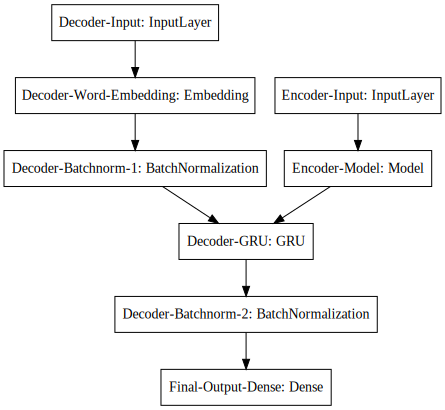

In [84]:
seq2seq_Model.summary()
viz_model_architecture(seq2seq_Model)

In [85]:
from keras.callbacks import CSVLogger, ModelCheckpoint

script_name_base = 'tutorial_seq2seq'
csv_logger = CSVLogger('{:}.log'.format(script_name_base))
model_checkpoint = ModelCheckpoint('{:}.epoch{{epoch:02d}}-val{{val_loss:.5f}}.hdf5'.format(script_name_base),
                                   save_best_only=True)

batch_size = 1200
epochs = 7
history = seq2seq_Model.fit([encoder_input_data, decoder_input_data], np.expand_dims(decoder_target_data, -1),
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.12, callbacks=[csv_logger, model_checkpoint])

Train on 15840 samples, validate on 2160 samples
Epoch 1/7
15840/15840 [==============================] - 388s 25ms/step - loss: 6.1814 - val_loss: 3.9811


/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer Decoder-GRU was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'Encoder-Model/Encoder-Last-GRU/while/Exit_3:0' shape=(?, 300) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/7
15840/15840 [==============================] - 361s 23ms/step - loss: 4.0355 - val_loss: 3.5841
Epoch 3/7
15840/15840 [==============================] - 310s 20ms/step - loss: 3.4668 - val_loss: 3.5865
Epoch 4/7
15840/15840 [==============================] - 306s 19ms/step - loss: 3.2316 - val_loss: 3.5538
Epoch 5/7
15840/15840 [==============================] - 313s 20ms/step - loss: 3.0498 - val_loss: 3.5629
Epoch 6/7
15840/15840 [==============================] - 307s 19ms/step - loss: 2.8859 - val_loss: 3.5203
Epoch 7/7
15840/15840 [==============================] - 350s 22ms/step - loss: 2.7186 - val_loss: 3.4659


In [109]:
class Seq2Seq_Inference(object):
    def __init__(self,
                 encoder_preprocessor,
                 decoder_preprocessor,
                 seq2seq_model):

        self.pp_body = encoder_preprocessor
        self.pp_title = decoder_preprocessor
        self.seq2seq_model = seq2seq_model
        self.encoder_model = extract_encoder_model(seq2seq_model)
        self.decoder_model = extract_decoder_model(seq2seq_model)
        self.default_max_len_title = self.pp_title.padding_maxlen
        self.nn = None
        self.rec_df = None

    def generate_issue_title(self,
                             raw_input_text,
                             max_len_title=None):
        """
        Use the seq2seq model to generate a title given the body of an issue.
        Inputs
        ------
        raw_input: str
            The body of the issue text as an input string
        max_len_title: int (optional)
            The maximum length of the title the model will generate
        """
        if max_len_title is None:
            max_len_title = self.default_max_len_title
        # get the encoder's features for the decoder
        raw_tokenized = self.pp_body.transform([raw_input_text])
        body_encoding = self.encoder_model.predict(raw_tokenized)
        # we want to save the encoder's embedding before its updated by decoder
        #   because we can use that as an embedding for other tasks.
        original_body_encoding = body_encoding
        state_value = np.array(self.pp_title.token2id['_start_']).reshape(1, 1)

        decoded_sentence = []
        stop_condition = False
        while not stop_condition:
            preds, st = self.decoder_model.predict([state_value, body_encoding])

            # We are going to ignore indices 0 (padding) and indices 1 (unknown)
            # Argmax will return the integer index corresponding to the
            #  prediction + 2 b/c we chopped off first two
            pred_idx = np.argmax(preds[:, :, 2:]) + 2

            # retrieve word from index prediction
            pred_word_str = self.pp_title.id2token[pred_idx]

            if pred_word_str == '_end_' or len(decoded_sentence) >= max_len_title:
                stop_condition = True
                break
            decoded_sentence.append(pred_word_str)

            # update the decoder for the next word
            body_encoding = st
            state_value = np.array(pred_idx).reshape(1, 1)

        return original_body_encoding, ' '.join(decoded_sentence)


    def print_example(self,
                      i,
                      body_text,
                      title_text,
                      threshold):
        """
        Prints an example of the model's prediction for manual inspection.
        """
        if i:
            print('\n\n==============================================')
            print(f'============== Example # {i} =================\n')


        print(f"Context:\n {body_text} \n")

        if title_text:
            print(f"Original Utterance:\n {title_text}")

        emb, gen_title = self.generate_issue_title(body_text)
        print(f"\n****** Machine Generated Utterance (Prediction) ******:\n {gen_title}")

        if self.nn:
            # return neighbors and distances
            n, d = self.nn.get_nns_by_vector(emb.flatten(), n=4,
                                             include_distances=True)
            neighbors = n[1:]
            dist = d[1:]

            if min(dist) <= threshold:
                cols = ['issue_title', 'body']
                dfcopy = self.rec_df.iloc[neighbors][cols].copy(deep=True)
                dfcopy['dist'] = dist
                similar_issues_df = dfcopy.query(f'dist <= {threshold}')

                print("\n**** Similar Issues (using encoder embedding) ****:\n")
                display(similar_issues_df)


    def demo_model_predictions(self,
                               n,
                               issue_df,
                               threshold=1):
        """
        Pick n random Issues and display predictions.
        Input:
        ------
        n : int
            Number of issues to display from issue_df
        issue_df : pandas DataFrame
            DataFrame that contains two columns: `body` and `issue_title`.
        threshold : float
            distance threshold for recommendation of similar issues.
        Returns:
        --------
        None
            Prints the original issue body and the model's prediction.
        """
        # Extract body and title from DF
        body_text = issue_df.Context.tolist()
        title_text = issue_df.Utterance.tolist()

        demo_list = np.random.randint(low=1, high=len(body_text), size=n)
        for i in demo_list:
            self.print_example(i,
                               body_text=body_text[i],
                               title_text=title_text[i],
                               threshold=threshold)

    def prepare_recommender(self, vectorized_array, original_df):
        """
        Use the annoy library to build recommender
        Parameters
        ----------
        vectorized_array : List[List[int]]
            This is the list of list of integers that represents your corpus
            that is fed into the seq2seq model for training.
        original_df : pandas.DataFrame
            This is the original dataframe that has the columns
            ['issue_url', 'issue_title', 'body']
        Returns
        -------
        annoy.AnnoyIndex  object (see https://github.com/spotify/annoy)
        """
        self.rec_df = original_df
        emb = self.encoder_model.predict(x=vectorized_array,
                                         batch_size=vectorized_array.shape[0]//200)

        f = emb.shape[1]
        self.nn = AnnoyIndex(f)
        logging.warning('Adding embeddings')
        for i in tqdm(range(len(emb))):
            self.nn.add_item(i, emb[i])
        logging.warning('Building trees for similarity lookup.')
        self.nn.build(50)
        return self.nn

    def set_recsys_data(self, original_df):
        self.rec_df = original_df

    def set_recsys_annoyobj(self, annoyobj):
        self.nn = annoyobj

    def evaluate_model(self, holdout_bodies, holdout_titles):
        """
        Method for calculating BLEU Score.
        Parameters
        ----------
        holdout_bodies : List[str]
            These are the issue bodies that we want to summarize
        holdout_titles : List[str]
            This is the ground truth we are trying to predict --> issue titles
        Returns
        -------
        bleu : float
            The BLEU Score
        """
        actual, predicted = list(), list()
        assert len(holdout_bodies) == len(holdout_titles)
        num_examples = len(holdout_bodies)

        logging.warning('Generating predictions.')
        # step over the whole set TODO: parallelize this
        for i in tqdm_notebook(range(num_examples)):
            _, yhat = self.generate_issue_title(holdout_bodies[i])

            actual.append(self.pp_title.process_text([holdout_titles[i]])[0])
            predicted.append(self.pp_title.process_text([yhat])[0])
        # calculate BLEU score
        logging.warning('Calculating BLEU.')
        
        #must be careful with nltk api for corpus_bleu!, 
        # expects List[List[List[str]]] for ground truth, using List[List[str]] will give you
        # erroneous results.
        bleu = corpus_bleu([[a] for a in actual], predicted)
        return bleu

In [110]:
def extract_encoder_model(model):
    """
    Extract the encoder from the original Sequence to Sequence Model.
    Returns a keras model object that has one input (body of issue) and one
    output (encoding of issue, which is the last hidden state).
    Input:
    -----
    model: keras model object
    Returns:
    -----
    keras model object
    """
    encoder_model = model.get_layer('Encoder-Model')
    return encoder_model

In [114]:
def extract_decoder_model(model):
    """
    Extract the decoder from the original model.
    Inputs:
    ------
    model: keras model object
    Returns:
    -------
    A Keras model object with the following inputs and outputs:
    Inputs of Keras Model That Is Returned:
    1: the embedding index for the last predicted word or the <Start> indicator
    2: the last hidden state, or in the case of the first word the hidden state from the encoder
    Outputs of Keras Model That Is Returned:
    1.  Prediction (class probabilities) for the next word
    2.  The hidden state of the decoder, to be fed back into the decoder at the next time step
    Implementation Notes:
    ----------------------
    Must extract relevant layers and reconstruct part of the computation graph
    to allow for different inputs as we are not going to use teacher forcing at
    inference time.
    """
    # the latent dimension is the same throughout the architecture so we are going to
    # cheat and grab the latent dimension of the embedding because that is the same as what is
    # output from the decoder
    latent_dim = model.get_layer('Decoder-Word-Embedding').output_shape[-1]

    # Reconstruct the input into the decoder
    decoder_inputs = model.get_layer('Decoder-Input').input
    dec_emb = model.get_layer('Decoder-Word-Embedding')(decoder_inputs)
    dec_bn = model.get_layer('Decoder-Batchnorm-1')(dec_emb)

    # Instead of setting the intial state from the encoder and forgetting about it, during inference
    # we are not doing teacher forcing, so we will have to have a feedback loop from predictions back into
    # the GRU, thus we define this input layer for the state so we can add this capability
    gru_inference_state_input = Input(shape=(latent_dim,), name='hidden_state_input')

    # we need to reuse the weights that is why we are getting this
    # If you inspect the decoder GRU that we created for training, it will take as input
    # 2 tensors -> (1) is the embedding layer output for the teacher forcing
    #                  (which will now be the last step's prediction, and will be _start_ on the first time step)
    #              (2) is the state, which we will initialize with the encoder on the first time step, but then
    #                   grab the state after the first prediction and feed that back in again.
    gru_out, gru_state_out = model.get_layer('Decoder-GRU')([dec_bn, gru_inference_state_input])

    # Reconstruct dense layers
    dec_bn2 = model.get_layer('Decoder-Batchnorm-2')(gru_out)
    dense_out = model.get_layer('Final-Output-Dense')(dec_bn2)
    decoder_model = Model([decoder_inputs, gru_inference_state_input],
                          [dense_out, gru_state_out])
    return decoder_model

In [115]:
seq2seq_inf = Seq2Seq_Inference(encoder_preprocessor=context_pp,
                                 decoder_preprocessor=utterance_pp,
                                 seq2seq_model=seq2seq_Model)

In [116]:
seq2seq_inf.demo_model_predictions(n=50, issue_df=testdf)



============== Example # 1660 =================

Context:
 i am not mixed up in anything hayseed what are you talking about 

Original Utterance:
 you just strike me as smart enough to be doing something else

****** Machine Generated Utterance (Prediction) ******:
 you are not going to be a little girl


============== Example # 713 =================

Context:
 watching the bitch trash my car does not count as a date 

Original Utterance:
 i got her under control she just acts crazed in public to keep up the image

****** Machine Generated Utterance (Prediction) ******:
 do not know what you are going to be a little girl


============== Example # 1914 =================

Context:
 the oh the spire how silly of me it is as plain as day mr merrick where did you learn to do this 

Original Utterance:
 i learned a long time ago

****** Machine Generated Utterance (Prediction) ******:
 i am not going to be a little girl


============== Example # 251 =================

Context:
 i am not


****** Machine Generated Utterance (Prediction) ******:
 i am not going to be a little girl


============== Example # 1669 =================

Context:
 this is the copy of swayzak's manning report that was released everybody on this job knows it is bullshit but we could never argue with the numbers they are all airtight 

Original Utterance:
 yeah airtight

****** Machine Generated Utterance (Prediction) ******:
 i am not going to be a little girl


============== Example # 672 =================

Context:
 if you are thinking of warning him do not put yourself out he cannot possibly escape 

Original Utterance:
 i stick my neck out for nobody

****** Machine Generated Utterance (Prediction) ******:
 oh oh i am not going to be a little girl


============== Example # 111 =================

Context:
 abort reed i put my company my name billions of dollars on the line and i will not let you make me look like a fool 

Original Utterance:
 victor if we could understand what happened to us

# Code 2

In [18]:
# Importing the libraries
import numpy as np
import tensorflow as tf
import re # For cleaning and replacing the texts of the corpus
import time # To measure the training time

In [19]:
data

,Context,Utterance
0,well i thought we would start with pronunciati...,not the hacking and gagging and spitting part ...
1,not the hacking and gagging and spitting part ...,okay then how 'bout we try out some french cui...
2,you are asking me out that is so cute what is ...,forget it
3,no no it is my fault we did not have a proper ...,cameron cameron
4,cameron cameron,the thing is cameron i am at the mercy of a pa...
5,the thing is cameron i am at the mercy of a pa...,seems like she could get a date easy enough
6,why why,unsolved mystery she used to be really popular...
7,unsolved mystery she used to be really popular...,that is a shame
8,gosh if only we could find kat a boyfriend,let me see what i can do
9,that is because it is such a nice one,forget french


In [40]:
clean_questions = data.Context.tolist()
clean_answers = data.Utterance.tolist()

In [41]:
short_questions = []
short_answers = []
i = 0
for question in clean_questions:
    if 2 <= len(question.split()) <= 25: # Taking a range from 2 to 25 for the training of dataset (since both short will be deficient and long data will be overwhelming for chatbot to learn)
        short_questions.append(question)
        short_answers.append(clean_answers[i])
    i += 1 # Incrementing the value of i so that it iterates each and every conversation
# In the above step, we filter from the questions and include the subsequent answers
clean_questions = []
clean_answers = []
i = 0
for answer in short_answers:
    if 2 <= len(answer.split()) <= 25:
        clean_answers.append(answer)
        clean_questions.append(short_questions[i])
    i += 1

In [42]:
word2count = {} 
for question in clean_questions:
    for word in question.split():
        if word not in word2count:
            word2count[word] = 1 # If the word is not present in dictionary, initiate its count
        else:
            word2count[word] += 1 # If the word is already included in the dictionary, increment the count by 1
for answer in clean_answers:
    for word in answer.split():
        if word not in word2count:
            word2count[word] = 1
        else:
            word2count[word] += 1

In [43]:
threshold_questions = 15 # Creating a threshold so as to include only the words with occurences greater than or equal to 15
questionswords2int = {}
word_number = 0 
for word, count in word2count.items():
    if count >= threshold_questions:
        questionswords2int[word] = word_number
        word_number += 1
threshold_answers = 15 # Instead of using two different variables for threshold, we can use just a single variable
answerswords2int = {}
word_number = 0
for word, count in word2count.items():
    if count >= threshold_answers:
        answerswords2int[word] = word_number
        word_number += 1

In [44]:
tokens = ['<PAD>', '<EOS>', '<OUT>', '<SOS>']
for token in tokens:
    questionswords2int[token] = len(questionswords2int) + 1 # Since upper-bound value is excluded, so +1 to include the upper_bound value
for token in tokens:
    answerswords2int[token] = len(answerswords2int) + 1

In [45]:
answersints2word = {w_i: w for w, w_i in answerswords2int.items()}
 
# Step 11: Adding <EOS> to end of every answer in the dictionary
for i in range(len(clean_answers)):
    clean_answers[i] += ' <EOS>'

In [46]:
questions_into_int = []
for question in clean_questions:
    ints = []
    for word in question.split(): # Traversing each and every word present in the clean_questions list
        if word not in questionswords2int:
            ints.append(questionswords2int['<OUT>'])
        else:
            ints.append(questionswords2int[word])
    questions_into_int.append(ints)
answers_into_int = []
for answer in clean_answers:
    ints = []
    for word in answer.split():
        if word not in answerswords2int:
            ints.append(answerswords2int['<OUT>'])
        else:
            ints.append(answerswords2int[word])
    answers_into_int.append(ints)

In [47]:
sorted_clean_questions = []
sorted_clean_answers = []
for length in range(1, 25 + 1): # Even though the range is from 1 to 25, but the questions with minimum words will have atleast 2 words due to previous constraints
    for i in enumerate(questions_into_int):
        if len(i[1]) == length:
            sorted_clean_questions.append(questions_into_int[i[0]])
            sorted_clean_answers.append(answers_into_int[i[0]])

In [48]:
def model_inputs(): # Function for defining tensorflow placeholders
    inputs = tf.placeholder(tf.int32, [None, None], name = 'input') 
    targets = tf.placeholder(tf.int32, [None, None], name = 'target')
    lr = tf.placeholder(tf.float32, name = 'learning_rate')
    keep_prob = tf.placeholder(tf.float32, name = 'keep_prob')
    return inputs, targets, lr, keep_prob
def preprocess_targets(targets, word2int, batch_size): # The targets must be in batches & each of the answers of the target must start with SOS token
    left_side = tf.fill([batch_size, 1], word2int['<SOS>']) # Making a vector of <SOS> token, size being batch_size*1
    right_side = tf.strided_slice(targets, [0,0], [batch_size, -1], [1,1]) # Making a vector targets without the last column and slided element by element
    preprocessed_targets = tf.concat([left_side, right_side], 1) # Concatenating both the vectors horizontally
    return preprocessed_targets
def encoder_rnn(rnn_inputs, rnn_size, num_layers, keep_prob, sequence_length):
    lstm = tf.contrib.rnn.BasicLSTMCell(rnn_size) 
    lstm_dropout = tf.contrib.rnn.DropoutWrapper(lstm, input_keep_prob = keep_prob) # Applying dropout to LSTM so as to drop specific no of neurons during training of chatbot so as train it efficiently
    encoder_cell = tf.contrib.rnn.MultiRNNCell([lstm_dropout] * num_layers)
    _, encoder_state = tf.nn.bidirectional_dynamic_rnn(cell_fw = encoder_cell, # The underscore is initially used because bidirectional rnn gives 2 output but we are interested in just the second one
                                                                    cell_bw = encoder_cell,
                                                                    sequence_length = sequence_length,
                                                                    inputs = rnn_inputs,
                                                                    dtype = tf.float32)
    return encoder_state
def decode_training_set(encoder_state, decoder_cell, decoder_embedded_input, sequence_length, decoding_scope, output_function, keep_prob, batch_size):
    attention_states = tf.zeros([batch_size, 1, decoder_cell.output_size]) # A three dimensional matrix of zeros
    attention_keys, attention_values, attention_score_function, attention_construct_function = tf.contrib.seq2seq.prepare_attention(attention_states, attention_option = "bahdanau", num_units = decoder_cell.output_size)
    training_decoder_function = tf.contrib.seq2seq.attention_decoder_fn_train(encoder_state[0],
                                                                              attention_keys,
                                                                              attention_values,
                                                                              attention_score_function,
                                                                              attention_construct_function,
                                                                              name = "attn_dec_train")
    decoder_output, _, _ = tf.contrib.seq2seq.dynamic_rnn_decoder(decoder_cell, # Again underscores used due to the similar reasons as mentioned in the above function
                                                                  training_decoder_function,
                                                                  decoder_embedded_input,
                                                                  sequence_length,
                                                                  scope = decoding_scope)
    decoder_output_dropout = tf.nn.dropout(decoder_output, keep_prob)
    return output_function(decoder_output_dropout)
def decode_test_set(encoder_state, decoder_cell, decoder_embeddings_matrix, sos_id, eos_id, maximum_length, num_words, decoding_scope, output_function, keep_prob, batch_size):
    attention_states = tf.zeros([batch_size, 1, decoder_cell.output_size]) # A three dimensional matrix of zeros
    attention_keys, attention_values, attention_score_function, attention_construct_function = tf.contrib.seq2seq.prepare_attention(attention_states, attention_option = "bahdanau", num_units = decoder_cell.output_size)
    test_decoder_function = tf.contrib.seq2seq.attention_decoder_fn_inference(output_function,
                                                                              encoder_state[0],
                                                                              attention_keys,
                                                                              attention_values,
                                                                              attention_score_function,
                                                                              attention_construct_function,
                                                                              decoder_embeddings_matrix,
                                                                              sos_id,
                                                                              eos_id,
                                                                              maximum_length,
                                                                              num_words,
                                                                              name = "attn_dec_inf")
    test_predictions, _, _ = tf.contrib.seq2seq.dynamic_rnn_decoder(decoder_cell,
                                                                    test_decoder_function,
                                                                    scope = decoding_scope)
    return test_predictions

In [49]:
def decoder_rnn(decoder_embedded_input, decoder_embeddings_matrix, encoder_state, num_words, sequence_length, rnn_size, num_layers, word2int, keep_prob, batch_size):
    with tf.variable_scope("decoding") as decoding_scope:
        lstm = tf.contrib.rnn.BasicLSTMCell(rnn_size)
        lstm_dropout = tf.contrib.rnn.DropoutWrapper(lstm, input_keep_prob = keep_prob)
        decoder_cell = tf.contrib.rnn.MultiRNNCell([lstm_dropout] * num_layers)
        weights = tf.truncated_normal_initializer(stddev = 0.1) # Getting weights to be a truncated normal distribution
        biases = tf.zeros_initializer() # Initializing biases value to be 0
        output_function = lambda x: tf.contrib.layers.fully_connected(x,
                                                                      num_words,
                                                                      None,
                                                                      scope = decoding_scope,
                                                                      weights_initializer = weights,
                                                                      biases_initializer = biases)
        training_predictions = decode_training_set(encoder_state,
                                                   decoder_cell,
                                                   decoder_embedded_input,
                                                   sequence_length,
                                                   decoding_scope,
                                                   output_function,
                                                   keep_prob,
                                                   batch_size)
        decoding_scope.reuse_variables() # So as to use the same variables as used in the above function
        test_predictions = decode_test_set(encoder_state,
                                           decoder_cell,
                                           decoder_embeddings_matrix,
                                           word2int['<SOS>'],
                                           word2int['<EOS>'],
                                           sequence_length - 1,
                                           num_words,
                                           decoding_scope,
                                           output_function,
                                           keep_prob,
                                           batch_size)
    return training_predictions, test_predictions

In [50]:
def seq2seq_model(inputs, targets, keep_prob, batch_size, sequence_length, answers_num_words, questions_num_words, encoder_embedding_size, decoder_embedding_size, rnn_size, num_layers, questionswords2int):
    encoder_embedded_input = tf.contrib.layers.embed_sequence(inputs,
                                                              answers_num_words + 1,
                                                              encoder_embedding_size,
                                                              initializer = tf.random_uniform_initializer(0, 1))
    encoder_state = encoder_rnn(encoder_embedded_input, rnn_size, num_layers, keep_prob, sequence_length)
    preprocessed_targets = preprocess_targets(targets, questionswords2int, batch_size)
    decoder_embeddings_matrix = tf.Variable(tf.random_uniform([questions_num_words + 1, decoder_embedding_size], 0, 1))
    decoder_embedded_input = tf.nn.embedding_lookup(decoder_embeddings_matrix, preprocessed_targets)
    training_predictions, test_predictions = decoder_rnn(decoder_embedded_input,
                                                         decoder_embeddings_matrix,
                                                         encoder_state,
                                                         questions_num_words,
                                                         sequence_length,
                                                         rnn_size,
                                                         num_layers,
                                                         questionswords2int,
                                                         keep_prob,
                                                         batch_size)
    return training_predictions, test_predictions

In [58]:
epochs = 10
batch_size = 32
rnn_size = 32
num_layers = 2
encoding_embedding_size = 32
decoding_embedding_size = 32
learning_rate = 0.001
learning_rate_decay = 0.9
min_learning_rate = 0.0001
keep_probability = 0.5

In [59]:
tf.reset_default_graph()
session = tf.InteractiveSession()
 
# Step 3: Loading the model inputs
inputs, targets, lr, keep_prob = model_inputs()
 
# Step 4: Setting the sequence length (will be max of the data length in dataset)
sequence_length = tf.placeholder_with_default(25, None, name = 'sequence_length')
 
# Step 5: Getting the shape of the inputs tensor
input_shape = tf.shape(inputs)
 
# Step 6: Getting the training and test predictions
training_predictions, test_predictions = seq2seq_model(tf.reverse(inputs, [-1]),
                                                       targets,
                                                       keep_prob,
                                                       batch_size,
                                                       sequence_length,
                                                       len(answerswords2int),
                                                       len(questionswords2int),
                                                       encoding_embedding_size,
                                                       decoding_embedding_size,
                                                       rnn_size,
                                                       num_layers,
                                                       questionswords2int)

In [60]:
with tf.name_scope("optimization"):
    loss_error = tf.contrib.seq2seq.sequence_loss(training_predictions,
                                                  targets,
                                                  tf.ones([input_shape[0], sequence_length]))
    optimizer = tf.train.AdamOptimizer(learning_rate)
    gradients = optimizer.compute_gradients(loss_error)
    clipped_gradients = [(tf.clip_by_value(grad_tensor, -5., 5.), grad_variable) for grad_tensor, grad_variable in gradients if grad_tensor is not None] # Clipping the gradient from -5 to 5
    optimizer_gradient_clipping = optimizer.apply_gradients(clipped_gradients)

In [61]:
def apply_padding(batch_of_sequences, word2int):
    max_sequence_length = max([len(sequence) for sequence in batch_of_sequences]) # Max length data used so as to get a proper padding of data so that each data is of same and equal length
    return [sequence + [word2int['<PAD>']] * (max_sequence_length - len(sequence)) for sequence in batch_of_sequences]
 
# Step 9: Splitting the data into batches of questions and answers
def split_into_batches(questions, answers, batch_size):
    for batch_index in range(0, len(questions) // batch_size):
        start_index = batch_index * batch_size
        questions_in_batch = questions[start_index : start_index + batch_size]
        answers_in_batch = answers[start_index : start_index + batch_size]
        padded_questions_in_batch = np.array(apply_padding(questions_in_batch, questionswords2int))
        padded_answers_in_batch = np.array(apply_padding(answers_in_batch, answerswords2int))
        yield padded_questions_in_batch, padded_answers_in_batch


In [62]:
training_validation_split = int(len(sorted_clean_questions) * 0.15)
training_questions = sorted_clean_questions[training_validation_split:]
training_answers = sorted_clean_answers[training_validation_split:]
validation_questions = sorted_clean_questions[:training_validation_split]
validation_answers = sorted_clean_answers[:training_validation_split]

In [63]:
batch_index_check_training_loss = 100 # Checking training loss every 100 epochs
batch_index_check_validation_loss = ((len(training_questions)) // batch_size // 2) - 1 # Checking validation loss every half of batch size
total_training_loss_error = 0
list_validation_loss_error = []
early_stopping_check = 0 # This value gets incremented by 1 if the loss error doesn't increase with each iteration
early_stopping_stop = 100 # Used to check if the early_stopping_check becomes its equal, if yes, then we break the process
checkpoint = "chatbot_weights.ckpt"
session.run(tf.global_variables_initializer())


In [64]:
for epoch in range(1, epochs + 1):
    for batch_index, (padded_questions_in_batch, padded_answers_in_batch) in enumerate(split_into_batches(training_questions, training_answers, batch_size)):
        starting_time = time.time()
        _, batch_training_loss_error = session.run([optimizer_gradient_clipping, loss_error], {inputs: padded_questions_in_batch,
                                                                                               targets: padded_answers_in_batch,
                                                                                               lr: learning_rate,
                                                                                               sequence_length: padded_answers_in_batch.shape[1],
                                                                                               keep_prob: keep_probability})
        total_training_loss_error += batch_training_loss_error
        ending_time = time.time()
        batch_time = ending_time - starting_time
        if batch_index % batch_index_check_training_loss == 0:
            print('Epoch: {:>3}/{}, Batch: {:>4}/{}, Training Loss Error: {:>6.3f}, Training Time on 100 Batches: {:d} seconds'.format(epoch,
                                                                                                                                       epochs,
                                                                                                                                       batch_index,
                                                                                                                                       len(training_questions) // batch_size,
                                                                                                                                       total_training_loss_error / batch_index_check_training_loss,
                                                                                                                                       int(batch_time * batch_index_check_training_loss)))
            total_training_loss_error = 0
        if batch_index % batch_index_check_validation_loss == 0 and batch_index > 0:
            total_validation_loss_error = 0
            starting_time = time.time()
            for batch_index_validation, (padded_questions_in_batch, padded_answers_in_batch) in enumerate(split_into_batches(validation_questions, validation_answers, batch_size)):
                batch_validation_loss_error = session.run(loss_error, {inputs: padded_questions_in_batch,
                                                                       targets: padded_answers_in_batch,
                                                                       lr: learning_rate,
                                                                       sequence_length: padded_answers_in_batch.shape[1],
                                                                       keep_prob: 1})
                total_validation_loss_error += batch_validation_loss_error
            ending_time = time.time()
            batch_time = ending_time - starting_time
            average_validation_loss_error = total_validation_loss_error / (len(validation_questions) / batch_size)
            print('Validation Loss Error: {:>6.3f}, Batch Validation Time: {:d} seconds'.format(average_validation_loss_error, int(batch_time)))
            learning_rate *= learning_rate_decay
            if learning_rate < min_learning_rate:
                learning_rate = min_learning_rate
            list_validation_loss_error.append(average_validation_loss_error)
            if average_validation_loss_error <= min(list_validation_loss_error):
                print('I am getting better as time goes by.')
                early_stopping_check = 0
                saver = tf.train.Saver()
                saver.save(session, checkpoint)
            else:
                print("I still need to practice more.")
                early_stopping_check += 1
                if early_stopping_check == early_stopping_stop:
                    break
    if early_stopping_check == early_stopping_stop:
        print("I can't speak any better, this is the best I can do.")
        break
print("Over")

Epoch:   1/10, Batch:    0/472, Training Loss Error:  0.072, Training Time on 100 Batches: 51 seconds
Epoch:   1/10, Batch:  100/472, Training Loss Error:  3.930, Training Time on 100 Batches: 16 seconds
Epoch:   1/10, Batch:  200/472, Training Loss Error:  2.455, Training Time on 100 Batches: 18 seconds
Validation Loss Error:  2.052, Batch Validation Time: 4 seconds
I am getting better as time goes by.
Epoch:   1/10, Batch:  300/472, Training Loss Error:  2.198, Training Time on 100 Batches: 21 seconds
Epoch:   1/10, Batch:  400/472, Training Loss Error:  2.144, Training Time on 100 Batches: 22 seconds
Validation Loss Error:  1.947, Batch Validation Time: 4 seconds
I am getting better as time goes by.
Epoch:   2/10, Batch:    0/472, Training Loss Error:  1.492, Training Time on 100 Batches: 18 seconds
Epoch:   2/10, Batch:  100/472, Training Loss Error:  1.999, Training Time on 100 Batches: 16 seconds
Epoch:   2/10, Batch:  200/472, Training Loss Error:  1.977, Training Time on 100 Ba

In [ ]:
checkpoint = "./chatbot_weights.ckpt" # Loading the weights after training from .ckpt file
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(session, checkpoint)

In [67]:
def convert_string2int(question, word2int):
    return [word2int.get(word, word2int['<OUT>']) for word in question.split()]

In [69]:
while(True):
    question = input("You: ")
    if question == 'Goodbye':
        break
    question = convert_string2int(question, questionswords2int)
    question = question + [questionswords2int['<PAD>']] * (25 - len(question))
    fake_batch = np.zeros((batch_size, 25))
    fake_batch[0] = question
    predicted_answer = session.run(test_predictions, {inputs: fake_batch, keep_prob: 0.5})[0]
    answer = ''
    for i in np.argmax(predicted_answer, 1):
        if answersints2word[i] == 'i':
            token = ' I'
        elif answersints2word[i] == '<EOS>':
            token = '.'
        elif answersints2word[i] == '<OUT>':
            token = 'out'
        else:
            token = ' ' + answersints2word[i]
        answer += token
        if token == '.':
            break
    print('ChatBot: ' + answer)

You: okay
ChatBot:  I amout.
You: oh i do not think so i gave him both barrels
ChatBot:  I amout.
You: accelerate to mark tommy
ChatBot:  I amout.
You: fuck you
ChatBot:  I do notout.
You: fart
ChatBot:  I amout.
You: not
ChatBot:  I do notout.
You: yes
ChatBot:  Iout.
You: hello?
ChatBot:  I amout.
You: where am I?
ChatBot:  I amout.
You: who are you
ChatBot:  I do not do notout.


KeyboardInterrupt: 

# Code 3

In [162]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math

In [163]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

In [164]:
corpus_name = "cornell movie-dialogs corpus"

In [165]:
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

In [166]:
class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

In [167]:
MAX_LENGTH = 30

In [168]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

In [169]:
def readVocs(data, corpus_name):
    print("Reading lines...")
    pairs = [[normalizeString(l),normalizeString(h)] for l,h in zip(data.Context.tolist(),data.Utterance.tolist())]
    voc = Voc(corpus_name)
    return voc, pairs

In [170]:
def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Filter pairs using filterPair condition
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [171]:
def loadPrepareData(corpus_name, data):
    print("Start preparing training data ...")
    voc, pairs = readVocs(data, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs

In [172]:
voc, pairs = loadPrepareData(corpus_name, data)

Start preparing training data ...
Reading lines...
Read 20000 sentence pairs
Trimmed to 18678 sentence pairs
Counting words...
Counted words: 10139


In [173]:
print("\npairs:")
for pair in pairs[:10]:
    print(pair)


pairs:
['well i thought we would start with pronunciation if that is okay with you', 'not the hacking and gagging and spitting part please']
['not the hacking and gagging and spitting part please', 'okay then how bout we try out some french cuisine saturday night']
['you are asking me out that is so cute what is your name again', 'forget it']
['no no it is my fault we did not have a proper introduction', 'cameron cameron']
['cameron cameron', 'the thing is cameron i am at the mercy of a particularly hideous breed of loser my sister i cannot date until she does']
['the thing is cameron i am at the mercy of a particularly hideous breed of loser my sister i cannot date until she does', 'seems like she could get a date easy enough']
['why why', 'unsolved mystery she used to be really popular when she started high school then it was just like she got sick of it or something']
['unsolved mystery she used to be really popular when she started high school then it was just like she got sick of

In [174]:
MIN_COUNT = 2

In [175]:
def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs

In [176]:
pairs = trimRareWords(voc, pairs, MIN_COUNT)

keep_words 7628 / 10136 = 0.7526
Trimmed from 18678 pairs to 16733, 0.8959 of total


In [177]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]

In [178]:
def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

In [179]:
def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

In [180]:
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

In [181]:
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.ByteTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

In [182]:
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len

In [183]:
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)

input_variable: tensor([[  86, 1596,   38,   14,  210],
        [ 301,  177,   85,   48, 2162],
        [  35, 4038,   65,   49,   43],
        [   4,   89,   68,  778,    2],
        [ 247,    4,    2,    2,    0],
        [ 100,  247,    0,    0,    0],
        [ 411, 1609,    0,    0,    0],
        [  14, 1853,    0,    0,    0],
        [ 229,   11,    0,    0,    0],
        [  77, 1321,    0,    0,    0],
        [ 100,    2,    0,    0,    0],
        [   2,    0,    0,    0,    0]])
lengths: tensor([12, 11,  5,  5,  4])
target_variable: tensor([[ 787,  155,  272,  438,  306],
        [ 787,  306,  272,  301,  141],
        [   2,  452,    4,   35, 1432],
        [   0,  155,   47,   73,   56],
        [   0,  306,   15,   14,  204],
        [   0,    2,  168,   33, 5367],
        [   0,    0,  142,  248,  325],
        [   0,    0, 1050,   11, 1114],
        [   0,    0,    3,  340,  135],
        [   0,    0,    2, 6805,  128],
        [   0,    0,    0, 1874,    6],
        

In [184]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

In [185]:
class Attn(torch.nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = torch.nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = torch.nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = torch.nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)


In [186]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

In [187]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

In [188]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

In [189]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

In [190]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

In [191]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words

In [192]:
def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

In [193]:
model_name = 'cb_model'
attn_model = 'dot'
#attn_model = 'general'
#attn_model = 'concat'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64

In [194]:
loadFilename = None
checkpoint_iter = 4000

In [195]:
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']

In [196]:
print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


In [203]:
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 100
print_every = 1
save_every = 500

In [204]:
encoder.train()
decoder.train()

LuongAttnDecoderRNN(
  (embedding): Embedding(7631, 500)
  (embedding_dropout): Dropout(p=0.1)
  (gru): GRU(500, 500, num_layers=2, dropout=0.1)
  (concat): Linear(in_features=1000, out_features=500, bias=True)
  (out): Linear(in_features=500, out_features=7631, bias=True)
  (attn): Attn()
)

In [205]:
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

Building optimizers ...


In [206]:
save_dir = None

In [207]:
print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)

Starting Training!
Initializing ...
Training...
Iteration: 1; Percent complete: 1.0%; Average loss: 5.8095
Iteration: 2; Percent complete: 2.0%; Average loss: 5.6306
Iteration: 3; Percent complete: 3.0%; Average loss: 5.6380
Iteration: 4; Percent complete: 4.0%; Average loss: 5.2660
Iteration: 5; Percent complete: 5.0%; Average loss: 4.8170
Iteration: 6; Percent complete: 6.0%; Average loss: 4.7903
Iteration: 7; Percent complete: 7.0%; Average loss: 4.9006
Iteration: 8; Percent complete: 8.0%; Average loss: 4.6920
Iteration: 9; Percent complete: 9.0%; Average loss: 4.3203
Iteration: 10; Percent complete: 10.0%; Average loss: 4.3323
Iteration: 11; Percent complete: 11.0%; Average loss: 4.2064
Iteration: 12; Percent complete: 12.0%; Average loss: 4.0289
Iteration: 13; Percent complete: 13.0%; Average loss: 4.2022
Iteration: 14; Percent complete: 14.0%; Average loss: 4.0798
Iteration: 15; Percent complete: 15.0%; Average loss: 3.8068
Iteration: 16; Percent complete: 16.0%; Average loss: 3

In [208]:
encoder.eval()
decoder.eval()

LuongAttnDecoderRNN(
  (embedding): Embedding(7631, 500)
  (embedding_dropout): Dropout(p=0.1)
  (gru): GRU(500, 500, num_layers=2, dropout=0.1)
  (concat): Linear(in_features=1000, out_features=500, bias=True)
  (out): Linear(in_features=500, out_features=7631, bias=True)
  (attn): Attn()
)

In [209]:
searcher = GreedySearchDecoder(encoder, decoder)

In [210]:
searcher

GreedySearchDecoder(
  (encoder): EncoderRNN(
    (embedding): Embedding(7631, 500)
    (gru): GRU(500, 500, num_layers=2, dropout=0.1, bidirectional=True)
  )
  (decoder): LuongAttnDecoderRNN(
    (embedding): Embedding(7631, 500)
    (embedding_dropout): Dropout(p=0.1)
    (gru): GRU(500, 500, num_layers=2, dropout=0.1)
    (concat): Linear(in_features=1000, out_features=500, bias=True)
    (out): Linear(in_features=500, out_features=7631, bias=True)
    (attn): Attn()
  )
)

In [212]:
evaluateInput(encoder, decoder, searcher, voc)

> Thanks 
Bot: i do not know you


KeyboardInterrupt: 